# This is where we calibrate our camera

First we load our chessboard images and use OpenCV2 to find the location of the corners on the image. 

In [60]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

shape = None
chessboard_corner_images = []

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    shape = gray.shape[::-1]
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        chessboard_corner_images.append(img)

 We draw lines between the corners and display them just to verify that the correct corners were detected. See below.

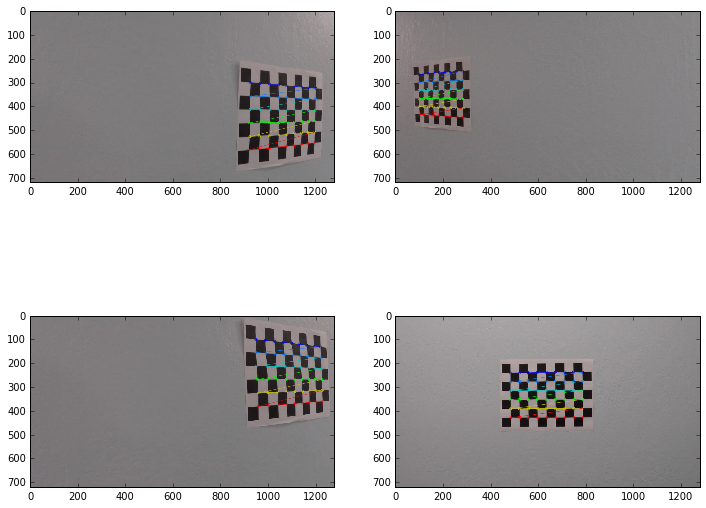

In [61]:
test_images = [0,2,5,7]

plt.figure(figsize=(12,10))
for plot_num, i in enumerate(test_images):
    plt.subplot(2,2,(plot_num + 1))
    plt.imshow(chessboard_corner_images[i])

Here we calculate the camera distortion matrix and the calibration matrix.  We use the OpenCV2 calibrateCamera function to do do this.  This function takes the locations of the previously detected corners on the chessboard.

In [63]:
%matplotlib inline
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)


Here we view some undistorted images using the previously calculated matrices.

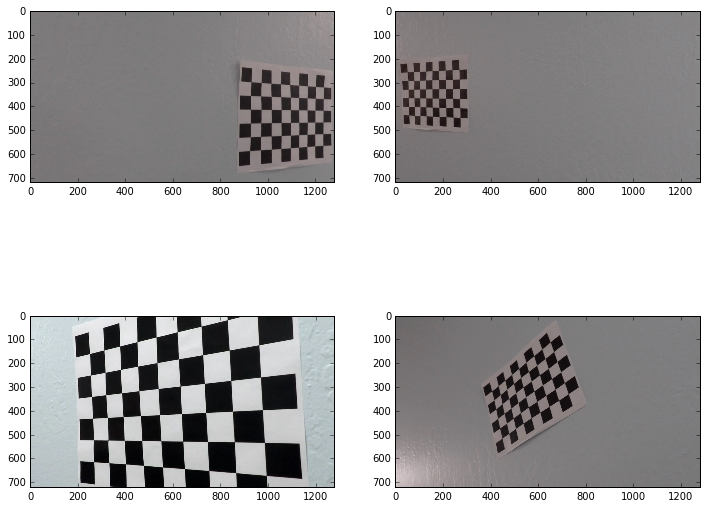

In [65]:
plt.figure(figsize=(12,10))
for plot_num, i in enumerate(test_images):
    dst = cv2.undistort(cv2.imread(images[i]), mtx, dist, None, mtx)
    plt.subplot(2,2,(plot_num + 1))
    plt.imshow(dst)

Here we view an undistorted image with straight lane lines.  We manually select 4 points to use for the perspective transform.

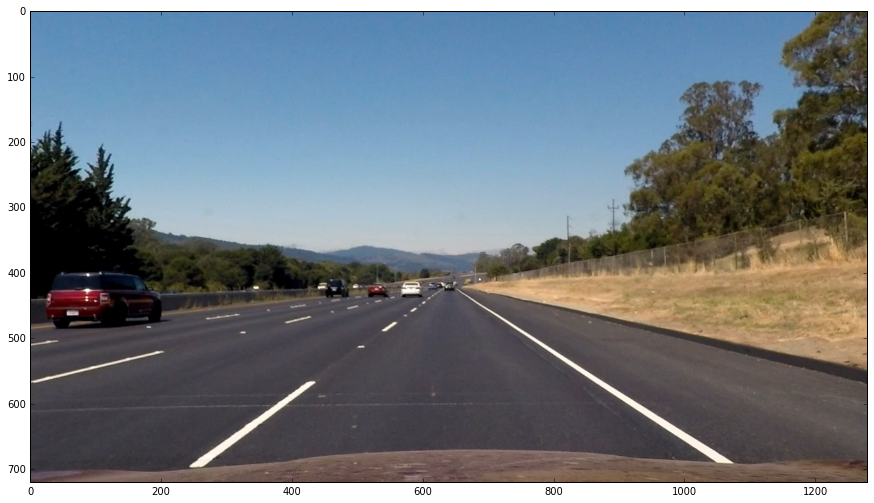

In [96]:
test_images = glob.glob('./test_images/*.jpg')

fig = plt.figure(figsize=(15,10))

img = plt.imread(test_images[6])
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)

From the image above we choose the following points and calculate the perspective transform matrix.

In [77]:
orig_points = np.float32([[210,725],[590,450],[685,450],[1110,725]])
dest_points = np.float32([[210,725],[210,0],[1110,0],[1110,725]])

M = cv2.getPerspectiveTransform(orig_points, dest_points)

Here we view the image after the perspective transform is applied to verify that the lines are vertical and parallel.

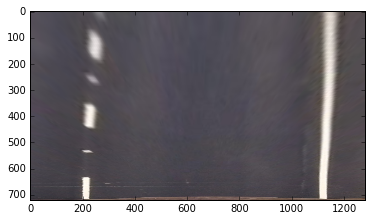

In [97]:
img = plt.imread(test_images[6])
undist = cv2.undistort(img, mtx, dist, None, mtx)
warped = cv2.warpPerspective(undist, M, (img.shape[1],img.shape[0]))
plt.imshow(warped)

# Calculate distortion coefficients

In [98]:
#import numpy as np
#import matplotlib.pyplot as plt
#import glob
#import cv2
#import time

#M = np.array([[ -7.36333209e-01,  -1.52041651e+00,   1.10230197e+03],
# [ -8.43769499e-15,  -1.94124210e+00,   8.73558944e+02],
# [ -1.06251813e-17,  -2.39494236e-03,   1.00000000e+00]])


#Minv = np.array([[  1.05555556e-01,  -7.83218391e-01,   5.67833333e+02],
# [  4.44089210e-16,  -5.15134100e-01,   4.50000000e+02],
# [ -4.33680869e-19,  -1.23371648e-03,   1.00000000e+00]])


#cameraMatrix = np.array([[  1.15396093e+03,   0.00000000e+00,   6.69705357e+02],
# [  0.00000000e+00,   1.14802496e+03,   3.85656234e+02],
# [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])


#distCoeff = np.array([[ -2.41017956e-01,  -5.30721171e-02,  -1.15810354e-03,  -1.28318858e-04,
#    2.67125302e-02]])



# Pipeline definition

The lane detection pipeline below does the following.
* Undistort the image using the previously calculated matrices from the calibration steps
* Apply thresholding to find the lane lines.  I combine two thresholding methods (one for white and yellow) that threshold on HLS values.
* Apply a perspective transform to create a top-down view of the lanes
* Fit a order 2 polynomial to both the left and right lane line
* Create a transparent overlay for the lane using the polynomials as sides to a polygon.

In [100]:
def undistort(img, cameraMatrix, distCoeff):
    return cv2.undistort(img, cameraMatrix, distCoeff, None, cameraMatrix)

def threshold_white(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    h_thresh = (0, 255)
    s_thresh = (0, 255)
    l_thresh = (200, 255)
    binary = np.zeros_like(S)
    binary[(L > l_thresh[0]) & (L <= l_thresh[1])] = 1
    return binary

def threshold_yellow(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    s_thresh = (100, 255)
    l_thresh = (100, 255)
    binary = np.zeros_like(S)
    binary[(S > s_thresh[0]) & (S <= s_thresh[1]) & (L > l_thresh[0]) & (L <= l_thresh[1])] = 1
    return binary

def threshold(img):
    yellow = threshold_yellow(img)
    white = threshold_white(img)
    return np.clip(white + yellow, 0, 1)

def perspective_transform(img, M):
    return cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]))

def fit_poly_to_lanes(img):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return(left_fit,right_fit)

def calculate_center_offset():
    pass

def calculate_curvature():
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    

def lane_overlay(img, Minv,left_fit,right_fit):
    ploty = np.linspace(0, img.shape[0]-1, num=img.shape[0])
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)


def pipeline(img, cameraMatrix, distCoeff, M):
    undist = undistort( img, cameraMatrix, distCoeff )
    thresholded = threshold(undist)
    persp = perspective_transform(thresholded, M)
    (left_fit,right_fit) = fit_poly_to_lanes(persp)
    overlay = lane_overlay(undist, Minv, left_fit, right_fit)    
    return overlay
    

Here we create a transparent overlay for the lane to verify that our lane detection algorithm works as expected.

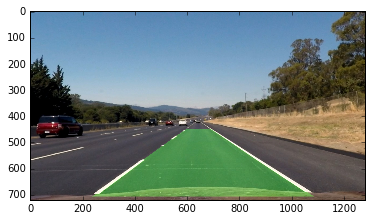

In [101]:
%matplotlib inline
test_images = glob.glob('./test_images/*.jpg')
straight_lane_lines = test_images[6]
img = plt.imread(straight_lane_lines)
lanes = pipeline(img, cameraMatrix, distCoeff, M)
plt.imshow(lanes, cmap="gray")    

Here we apply the transparent overlay to every frame in a video recording from the vehicle.

In [94]:
clip = clip1.fl_image(p)
%time clip.write_videofile(video_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="./project_video_output.mp4" type="video/mp4">
</video>
""".format(video_output))

